# ECE 590 - Lab2 - LeNet5 Cifar 10 - Anthony DiSpirito

## My Info
* **Name: Anthony DiSpirito**
* **NetID: ad424**
* **Class: ECE 590 - Comp Eng ML and DL**
* **Title: Lab2 - LeNet5 Cifar10**
* **Date: 10/2/19**

## Build LeNet5 Model

### Import Statements

In [3]:
import argparse
import os, sys
import math
import random
import time
import datetime
import csv
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

# Import pytorch dependencies
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm import tqdm_notebook as tqdm

# You cannot change this line.
from tools.dataloader import CIFAR10

### LeNet-5 Model Class

In [4]:
""" 
Assignment 2(a)
Build the LeNet-5 model by following table 1 or figure 1.

You can also insert batch normalization and leave the LeNet-5 
with batch normalization here for assignment 3(c).
"""
# Create the neural network module: LeNet-5
class LeNet5(nn.Module):
    def __init__(self):
        '''
        FUNCTIONS USED IN THIS SECTION:
        -----------------------------------------
        Conv2d Function takes form:
        
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
                        padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        -----------------------------------------
        BatchNorm2d Function takes the form:
        
        torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1,
                             affine=True, track_running_stats=True)
        -----------------------------------------
        Linear Function:
        torch.nn.Linear(in_features, out_features, bias=True)
        '''
        super(LeNet5, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 6, 5, padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros')
        self.bn_conv1 = nn.BatchNorm2d(6, eps=1e-05,momentum=0.1, 
                                       affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros')
        self.bn_conv2 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1,
                                       affine=True, track_running_stats=True)
        # Fully Connected Layers
        self.fc1 = nn.Linear(16*(5**2), 120, bias = True)
        self.fc2 = nn.Linear(120, 84, bias = True)     
        self.fc3 = nn.Linear(84, 10, bias = True)
        return
    
    def forward(self, x):
        # First Convolutional Layer (ReLu activation)
        out = F.relu(self.bn_conv1(self.conv1(x)))
        # First Pooling Layer (2x2 strides and pooling size)
        out = F.max_pool2d(out, 2)
        # Second Convolutional Layer (ReLu activation)
        out = F.relu(self.bn_conv2(self.conv2(out)))
        # Second Pooling Layer (2x2 strides and pooling size)
        out = F.max_pool2d(out, 2)
        # Reshapes "out" so we can input into Fully Connected Layer
        out = out.view(out.size(0), -1)
        # First Fully Connected Layer (ReLu activation)
        out = F.relu(self.fc1(out))
        # Second Fully Connected Layer (ReLu activation)
        out = F.relu(self.fc2(out))
        # Third Fully Connected Layer (Softmax activation)
        out = self.fc3(out)#F.softmax(self.fc3(out), dim=0)
        return out        

### Setting Hyperparameters

In [96]:
"""
Hyperparameter optimization in assignment 4(a), 4(b) can be 
conducted here.
Be sure to leave only your best hyperparameter combination
here and comment the original hyperparameter settings.
"""

# Setting some hyperparameters
TRAIN_BATCH_SIZE = 64#128
VAL_BATCH_SIZE = 50#100
INITIAL_LR = 0.01
MOMENTUM = 0.9
REG = 1e-4
EPOCHS = 100
DATAROOT = "./data"
CHECKPOINT_PATH = "./saved_model"

In [91]:
"""
Assignment 2(b)
Write functions to load dataset and preprocess the incoming data. 
We recommend that the preprocess scheme \textbf{must} include 
normalize, standardization, batch shuffling to make sure the training 
process goes smoothly. 
The preprocess scheme may also contain some data augmentation methods 
(e.g., random crop, random flip, etc.). 

Reference value for mean/std:

mean(RGB-format): (0.4914, 0.4822, 0.4465)
std(RGB-format): (0.2023, 0.1994, 0.2010)


NOTE: Considering this process has strong corrlelation with assignment 3(b), 
please leave the data preprocessing method which can achieve the highest 
validation accuracy here. You can include your original data augmentation
method as comments and denotes the accuracy difference between these two 
methods.
"""
# Specify preprocessing function.
# Reference mean/std value
mean_RGB = (0.4914, 0.4822, 0.4465)
std_RGB = (0.2023, 0.1994, 0.2010)
input_img_size = (32,32)
percent_crop = 0.80 # 80 percent left after crop
data_augment_list = [transforms.RandomVerticalFlip(p = 0.10),
                     transforms.RandomHorizontalFlip(p = 0.15),
                     transforms.RandomApply([transforms.RandomCrop(size = input_img_size, padding=4, pad_if_needed=False, fill=0, padding_mode='constant')], p = 0.15),
                     transforms.RandomApply([transforms.RandomAffine(degrees = 45, translate=(0.15,0.15), scale=None, shear=None, resample=False, fillcolor=0)], p = 0.20),
                     transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)], p = 0.15)]
transform_train = transforms.Compose([transforms.Resize(input_img_size),
                                      transforms.RandomOrder(data_augment_list),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(p=0.10, scale=(0.01, 0.15), ratio=(0.3, 3.3), value=0, inplace=False),
                                      transforms.Normalize(mean_RGB, std_RGB)])
transform_val = transforms.Compose([transforms.Resize(input_img_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean_RGB, std_RGB)])

In [88]:
# Call the dataset Loader
num_threads = 16
trainset = CIFAR10(root=DATAROOT, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=num_threads//2)
valset = CIFAR10(root=DATAROOT, train=False, download=True, transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=num_threads//2)

Using downloaded and verified file: ./data\cifar10_trainval.tar.gz
Extracting ./data\cifar10_trainval.tar.gz to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data\cifar10_trainval.tar.gz
Extracting ./data\cifar10_trainval.tar.gz to ./data
Files already downloaded and verified


In [97]:
# Specify the device for computation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5()
net = net.to(device)
if device =='cuda':
    print("Train on GPU...")
else:
    print("Train on CPU...")

Train on GPU...


In [98]:
# FLAG for loading the pretrained model
TRAIN_FROM_SCRATCH = True
# Code for loading checkpoint and recover epoch id.
CKPT_PATH = "./saved_model/model.h5"
def get_checkpoint(ckpt_path):
    try:
        ckpt = torch.load(ckpt_path)
    except Exception as e:
        print(e)
        return None
    return ckpt

ckpt = get_checkpoint(CKPT_PATH)
if ckpt is None or TRAIN_FROM_SCRATCH:
    if not TRAIN_FROM_SCRATCH:
        print("Checkpoint not found.")
    print("Training from scratch ...")
    start_epoch = 0
    current_learning_rate = INITIAL_LR
else:
    print("Successfully loaded checkpoint: %s" %CKPT_PATH)
    net.load_state_dict(ckpt['net'])
    start_epoch = ckpt['epoch'] + 1
    current_learning_rate = ckpt['lr']
    print("Starting from epoch %d " %start_epoch)

print("Starting from learning rate %f:" %current_learning_rate)

Training from scratch ...
Starting from learning rate 0.010000:


In [99]:
"""
Assignment 2(c)
In the targeted classification task, we use cross entropy loss with L2 
regularization as the learning object.
You need to formulate the cross-entropy loss function in PyTorch.
You should also specify a PyTorch Optimizer to optimize this loss function.
We recommend you to use the SGD-momentum with an initial learning rate 0.01 
and momentum 0.9 as a start.
"""
# Create loss function and specify regularization
criterion = nn.CrossEntropyLoss()
# Add optimizer
optimizer = optim.SGD(net.parameters(), INITIAL_LR, MOMENTUM, weight_decay=REG)

In [51]:
"""
Assignment 3(a) - Part 1
Start the training process over the whole CIFAR-10 training dataset. 
For sanity check, you are required to report the initial loss value at 
the beginning of the training process and briefly justify this value. 
"""

train_loss = 0
# Calculating initial loss
for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs/targets to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.data.item()
        #print(train_loss)
# Printing initial forward loss
forward_loss = train_loss/len(trainloader)
print("Initial Forward Loss: %.4f" %forward_loss)

Initial Forward Loss: 2.3080


In [100]:
"""
Assignment 3(a) - Part 2
Run the training process for \textbf{a maximum of 30} epochs and you 
should be able to reach around \textbf{65\%} accuracy on the validation 
dataset.
"""
# Start the training/validation process
# The process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.
global_step = 0
best_val_acc = 0
# Initializing Log Variables
avg_train_loss_log = np.zeros(EPOCHS)
avg_train_acc_log = np.zeros(EPOCHS)
avg_val_loss_log = np.zeros(EPOCHS)
avg_val_acc_log = np.zeros(EPOCHS)

for i in range(start_epoch, EPOCHS):
    print(datetime.datetime.now())
    # Switch to train mode
    net.train()
    print("Epoch %d:" %i)

    total_examples = 0
    correct_examples = 0

    train_loss = 0
    train_acc = 0
    # Train the training dataset for 1 epoch.
    print(len(trainloader))
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Copy inputs/targets to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Zero the gradient
        optimizer.zero_grad()
        # Generate output
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        # Calculate accuracy
        total_examples += targets.size(0)
        correct_examples += predicted.eq(targets.data).sum().item()
        train_loss += loss.data.item()

        global_step += 1
        if global_step % 100 == 0:
            avg_loss = train_loss / (batch_idx + 1)
        pass
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f %%" %(avg_loss, avg_acc*100))
    
    # Training Log
    avg_train_loss_log[i] = avg_loss
    avg_train_acc_log[i] = avg_acc
    
    print(datetime.datetime.now())
    # Validate on the validation dataset
    print("Validation...")
    total_examples = 0
    correct_examples = 0
    
    net.eval()

    val_loss = 0
    val_acc = 0
    # Disable gradient during validation
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            # Copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradient
            optimizer.zero_grad()
            # Generate output from the DNN.
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # Calculate predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Calculate accuracy
            total_examples += targets.size(0)
            correct_examples += predicted.eq(targets.data).sum().item()
            val_loss += loss.data.item()

    avg_loss = val_loss / len(valloader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f %%" %(avg_loss, avg_acc*100))
    
    # Validation Log
    avg_val_loss_log[i] = avg_loss
    avg_val_acc_log[i] = avg_acc
    
    """
    Assignment 4(b)
    Learning rate is an important hyperparameter to tune. Specify a 
    learning rate decay policy and apply it in your training process. 
    Briefly describe its impact on the learning curveduring your 
    training process.    
    Reference learning rate schedule: 
    decay 0.98 for every 2 epochs. You may tune this parameter but 
    minimal gain will be achieved.
    Assignment 4(c)
    As we can see from above, hyperparameter optimization is critical 
    to obtain a good performance of DNN models. Try to fine-tune the 
    model to over 70% accuracy. You may also increase the number of 
    epochs to up to 100 during the process. Briefly describe what you 
    have tried to improve the performance of the LeNet-5 model.
    """
    DECAY_EPOCHS = 2
    DECAY = 0.96#0.98
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = INITIAL_LR*(DECAY**(i//DECAY_EPOCHS))
        for param_group in optimizer.param_groups:
            # Assign the learning rate parameter
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %(current_learning_rate))
    
    # Save for checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'net': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'model.h5'))

print("Optimization finished.")

2019-10-03 23:21:43.754623
Epoch 0:
704
Training loss: 1.7348, Training accuracy: 35.8578 %
2019-10-03 23:21:54.799623
Validation...
Validation loss: 1.4301, Validation accuracy: 48.1600 %
Saving ...
2019-10-03 23:22:00.225621
Epoch 1:
704
Training loss: 1.4867, Training accuracy: 46.3311 %
2019-10-03 23:22:11.322623
Validation...
Validation loss: 1.3782, Validation accuracy: 50.4400 %
Saving ...
2019-10-03 23:22:16.834621
Epoch 2:
704
Training loss: 1.4044, Training accuracy: 49.2644 %
2019-10-03 23:22:27.953624
Validation...
Validation loss: 1.1798, Validation accuracy: 58.3000 %
Current learning rate has decayed to 0.009600
Saving ...
2019-10-03 23:22:33.269621
Epoch 3:
704
Training loss: 1.3413, Training accuracy: 52.1333 %
2019-10-03 23:22:44.386664
Validation...
Validation loss: 1.1804, Validation accuracy: 57.9800 %
2019-10-03 23:22:49.805622
Epoch 4:
704
Training loss: 1.3156, Training accuracy: 53.0911 %
2019-10-03 23:23:00.922624
Validation...
Validation loss: 1.1227, Validat

### Accuracy and Loss Analysis

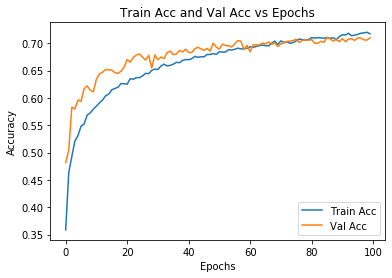

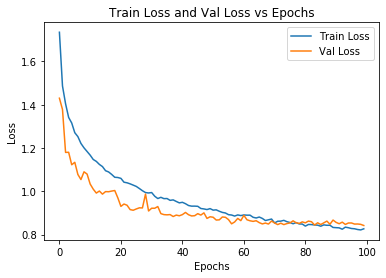

In [101]:
# Plotting Accuracy Curves
plt.plot(range(0, EPOCHS), avg_train_acc_log, range(0, EPOCHS), avg_val_acc_log)
plt.title("Train Acc and Val Acc vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Acc","Val Acc"])
plt.show()
# Plotting Loss Curves
plt.plot(range(0, EPOCHS), avg_train_loss_log, range(0, EPOCHS), avg_val_loss_log)
plt.title("Train Loss and Val Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss","Val Loss"])
plt.show()

In [102]:
# Saving Log Files
# Defining my Logging Object
with open('./logs/train_and_val_logs.csv', 'w') as filename:
    filename.write('epoch, train_loss, train_acc, val_acc, val_loss\n')
    for i in range(1, EPOCHS):
        filename.write("%d, %0.5f, %0.5f, %0.5f, %0.5f\n" % (i, avg_train_acc_log[i], avg_train_loss_log[i], avg_val_acc_log[i], avg_val_loss_log[i]))
        
